In [1]:
# !pip install torch_scatter torch_sparse torch_cluster torch_spline_conv
# !pip install torch_geometric

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn

from tqdm.auto import tqdm
from timeit import default_timer as timer

from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing

import warnings
warnings.filterwarnings("ignore")

In [3]:
# # If running in Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
output_path = 'output/models/'

In [5]:
# ls

In [6]:
# cd drive/MyDrive/RecSys_KB/Aleksis

In [7]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [18]:
movie_ratings_count = ratings['movieId'].value_counts(ascending=True)

In [21]:
X_train, X_test = train_test_split(ratings[['userId', 'movieId', 'rating']], stratify=ratings[['rating']], test_size=0.20, random_state=42)
X_train, X_val = train_test_split(X_train, stratify=X_train[['rating']], test_size=0.10, random_state=42)

In [24]:
users_train = X_train.userId.unique()

In [25]:
users_train = X_train.userId.unique()
movies_train = X_train.movieId.unique()

In [26]:
movies_with_enough_ratings = list(filter(lambda x: movie_ratings_count[x] >= 0, movies_train))

In [27]:
len(movies_with_enough_ratings)

8661

In [29]:
userid2idx = {o:i for i,o in enumerate(users_train)}
# userid2idx = {o:i + 1 for i,o in enumerate(ratings.userId.unique())}
# movieid2idx = {o:i + 1 for i,o in enumerate(movies_with_enough_ratings)}
movieid2idx = {o:i for i,o in enumerate(ratings.movieId.unique())}

In [30]:
idx2userid = {v:k  for k,v in userid2idx.items()}
idx2movieid = {v:k  for k,v in movieid2idx.items()}

In [33]:
num_users, num_movies = len(userid2idx), len(movieid2idx)
num_users, num_movies

(610, 9724)

In [35]:
movies

,movieId,title,genres,abstracts,abstracts_count,abstract_embeddings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995) genres: Adventure|Animation|C...,0,[-3.30134444e-02 -2.01094374e-02 7.14708790e-...
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji is a 1995 American fantasy adventure f...,1,[-1.18304212e-02 6.41161203e-02 9.13541857e-...
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...,1,[-4.35247384e-02 -2.99240090e-02 -1.32443719e-...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale (1995) genres: Comedy|Drama|...,0,[-6.43825084e-02 -6.76364526e-02 -1.91318002e-...
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II (1995) genres: Comedy,0,[-4.51376252e-02 -5.00504188e-02 -1.56385768e-...
...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,The Butler Bulldogs men's basketball team repr...,2,[ 3.13083529e-02 1.48075968e-02 3.68007384e-...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"No Game No Life (Japanese: ノーゲーム・ノーライフ, Hepbur...",1,[-1.92668010e-02 -4.74059843e-02 -8.06948766e-...
9739,193585,Flint (2017),Drama,Flint is a sedimentary cryptocrystalline form ...,1,[-5.53447567e-02 -1.97313577e-02 3.11960699e-...
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"Bungo Stray Dogs (Japanese: 文豪ストレイドッグス, Hepbur...",2,[-1.11603690e-03 -6.92510679e-02 1.85637157e-...


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [48]:
def get_edge_index(X):
    edge_index = [[], []]
    edge_values = []
    for i, row in X.iterrows():
        edge_index[0].append(userid2idx.get(row['userId'], 0))
        edge_index[1].append(movieid2idx.get(row['movieId'], 0))
        edge_values.append(row['rating'])

    return edge_index, edge_values

Bipartite graph user -> movie ratings

In [50]:
edge_index_train, edge_values_train = get_edge_index(X_train)
edge_index_val, edge_values_val     = get_edge_index(X_val)
edge_index_test, edge_values_test = get_edge_index(X_test)

In [51]:
len(edge_index_train[0]), len(edge_values_train)

(72601, 72601)

In [52]:
np.array(edge_index_train)[0]

array([ 0,  1,  2, ..., 57,  3, 38])

In [53]:
np.array(edge_index_train).shape

(2, 72601)

In [55]:
len(edge_index_train[0]) + len(edge_index_val[0]) + len(edge_index_test[0])

100836

In [56]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, input_edge_values):
    '''
    Converts adj matrix (num_users + num_movies) x (num_users + num_movies) to Bipartite graph user -> movie ratings
    '''

    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                           col=input_edge_index[1],
                                           value = input_edge_values,
                                           sparse_sizes=(num_users + num_movies, num_users + num_movies))

    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]

    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    r_mat_edge_values = interact_mat.to_sparse_coo().values()

    return r_mat_edge_index, r_mat_edge_values

In [58]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
    '''
    Converts Bipartite graph user -> movie ratings to adj matrix (num_users + num_movies) x (num_users + num_movies)
    '''
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = input_edge_values[i] # assign actual edge value to Interaction Matrix

    R_transpose = torch.transpose(R, 0, 1)

    # create adj_matrix
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()

    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    return adj_mat_coo_indices, adj_mat_coo_values

In [59]:
edge_index_train, edge_values_train = torch.tensor(edge_index_train), torch.tensor(edge_values_train)
edge_index_val,   edge_values_val   = torch.tensor(edge_index_val), torch.tensor(  edge_values_val)  
edge_index_test, edge_values_test   = torch.tensor(edge_index_test), torch.tensor(edge_values_test)  

In [61]:
adj_edge_index_train, adj_edge_values_train  = convert_r_mat_edge_index_to_adj_mat_edge_index(  edge_index_train, edge_values_train)
adj_edge_index_val, adj_edge_values_val     = convert_r_mat_edge_index_to_adj_mat_edge_index(   edge_index_val,   edge_values_val  )
adj_edge_index_test, adj_edge_values_test   = convert_r_mat_edge_index_to_adj_mat_edge_index(   edge_index_test, edge_values_test  )

In [65]:
r_mat_edge_index_train, r_mat_edge_values_train   = convert_adj_mat_edge_index_to_r_mat_edge_index(adj_edge_index_train, adj_edge_values_train)
r_mat_edge_index_val,   r_mat_edge_values_val     = convert_adj_mat_edge_index_to_r_mat_edge_index(adj_edge_index_val, adj_edge_values_val    )
r_mat_edge_index_test,  r_mat_edge_values_test    = convert_adj_mat_edge_index_to_r_mat_edge_index(adj_edge_index_test, adj_edge_values_test  )

In [73]:
edge_index_train = edge_index_train.to(device)

In [74]:
def train_step(model,
               edge_index_train,
               r_mat_edge_index_train,
               r_mat_edge_values_train,
               loss_fn,
               optimizer,
               device):

    model.train()
    y_pred = model(edge_index_train, r_mat_edge_index_train)

    loss = loss_fn(y_pred, r_mat_edge_values_train.view(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def test_step(model,
              edge_index_test,
              r_mat_edge_index_test,
              r_mat_edge_values_test,
              loss_fn,
              device):
    model.eval()

    with torch.inference_mode():

        y_pred = model(edge_index_test, r_mat_edge_index_test)

        loss = loss_fn(y_pred, r_mat_edge_values_test.view(-1, 1))

        return loss.item()

def train(model,
          optimizer,
          loss_fn,
          epochs,
          device,
          scheduler,
          edge_index_train=adj_edge_index_train,
          r_mat_edge_index_train=r_mat_edge_index_train,
          r_mat_edge_values_train=r_mat_edge_values_train,
          edge_index_test=adj_edge_index_val,
          r_mat_edge_index_test=r_mat_edge_index_val,
          r_mat_edge_values_test=r_mat_edge_values_val,
          results = {"train_loss": [],
               "test_loss": [],
    }
):
    model.to(device)

    best_loss = float('inf')

    edge_index_train = edge_index_train.to(device)
    r_mat_edge_index_train = r_mat_edge_index_train.to(device)
    r_mat_edge_values_train = r_mat_edge_values_train.float().to(device)
    edge_index_test = edge_index_test.to(device)
    r_mat_edge_index_test = r_mat_edge_index_test.to(device)
    r_mat_edge_values_test = r_mat_edge_values_test.float().to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss = train_step(model=model,
                                edge_index_train=edge_index_train,
                                r_mat_edge_index_train=r_mat_edge_index_train,
                                r_mat_edge_values_train=r_mat_edge_values_train,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        end_time = timer()
        test_loss = test_step(model=model,
                              edge_index_test=edge_index_test,
                              r_mat_edge_index_test=r_mat_edge_index_test,
                              r_mat_edge_values_test=r_mat_edge_values_test,
                              loss_fn=loss_fn,
                              device=device)

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        if epoch % 200 == 0 and epoch != 0:
            scheduler.step()

            if best_loss > test_loss:
                best_loss = test_loss
                print('Saving new best model.')
                model.save( output_path + model.name + ".pt")



            print(
              f"Epoch: {epoch} | "
              f"train_loss: {train_loss:.4f} | "
              f"train RMSE: {np.sqrt(train_loss):.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test RMSE: {np.sqrt(test_loss):.4f} | "
              f"time: {(end_time-start_time):.4f} "
              f"Learning rate: {next(iter(scheduler.optimizer.param_groups))['lr']}"
            )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

In [75]:
adj_edge_index_train.shape, r_mat_edge_index_train.shape, r_mat_edge_values_train.shape

(torch.Size([2, 145202]), torch.Size([2, 72601]), torch.Size([72601]))

In [76]:
adj_edge_index_train, r_mat_edge_index_train, r_mat_edge_values_train

(tensor([[    0,     0,     0,  ..., 10329, 10330, 10332],
         [  610,   614,   617,  ...,    13,    13,    13]]),
 tensor([[   0,    0,    0,  ...,  609,  609,  609],
         [   0,    4,    7,  ...,  902,  915, 1925]]),
 tensor([3.0000, 4.5000, 4.0000,  ..., 4.5000, 4.5000, 4.0000]))

In [78]:
class LightGCN(MessagePassing):

    def save(self, fileName):
        torch.save(self.state_dict(), fileName)

    def load(self, fileName, device):
        self.load_state_dict(torch.load(fileName, map_location=device))

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False, dropout_rate=0.1, name='name'):

        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops
        self.name = name
        self.drop1 = nn.Dropout(dropout_rate)


        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0

        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0


        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

        self.out = nn.Linear(embedding_dim + embedding_dim, 1)

    def forward(self, edge_index, r_mat_edge_index):
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embedding matrix
        # shape: (n_users + n_items) x embedding_dim. 
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list

        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)


        # this is doing the formula8 in LightGCN paper

        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x embedding_dim.
        embs = torch.stack(embs, dim=1)

        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1)

        users_emb_final, items_emb_final = torch.split(emb_final,
                                                       [self.num_users, self.num_items]) # splits into user embeddings and movie embeddings

        src, dest =  r_mat_edge_index[0], r_mat_edge_index[1]

        user_embeds = users_emb_final[src]
        item_embeds = items_emb_final[dest]
        # x.shape: n_ratings x  embedding_dim * 2
        x = torch.cat([user_embeds, item_embeds], dim=1)

        x = self.drop1(x)

        output = self.out(x)

        return output

In [79]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat ,y))

In [80]:
model = LightGCN(num_users=num_users, num_items=num_movies, embedding_dim=32, K=1, add_self_loops=True, dropout_rate=0.1, name="light_gcn") # best 0.9504
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=0.0001, threshold_mode='rel')

  0%|          | 0/15000 [00:00<?, ?it/s]

Saving new best model.
Epoch: 200 | train_loss: 3.3016 | train RMSE: 1.8170 | test_loss: 3.5843 | test RMSE: 1.8932 | time: 0.0031 Learning rate: 0.00095
Saving new best model.
Epoch: 400 | train_loss: 1.9035 | train RMSE: 1.3797 | test_loss: 2.0167 | test RMSE: 1.4201 | time: 0.0040 Learning rate: 0.0009025
Saving new best model.
Epoch: 600 | train_loss: 1.5611 | train RMSE: 1.2494 | test_loss: 1.6478 | test RMSE: 1.2837 | time: 0.0035 Learning rate: 0.000857375
Saving new best model.
Epoch: 800 | train_loss: 1.3898 | train RMSE: 1.1789 | test_loss: 1.4672 | test RMSE: 1.2113 | time: 0.0043 Learning rate: 0.0008145062499999999
Saving new best model.
Epoch: 1000 | train_loss: 1.2853 | train RMSE: 1.1337 | test_loss: 1.3545 | test RMSE: 1.1638 | time: 0.0038 Learning rate: 0.0007737809374999998
Saving new best model.
Epoch: 1200 | train_loss: 1.2105 | train RMSE: 1.1002 | test_loss: 1.2759 | test RMSE: 1.1296 | time: 0.0033 Learning rate: 0.0007350918906249997
Saving new best model.
Epo

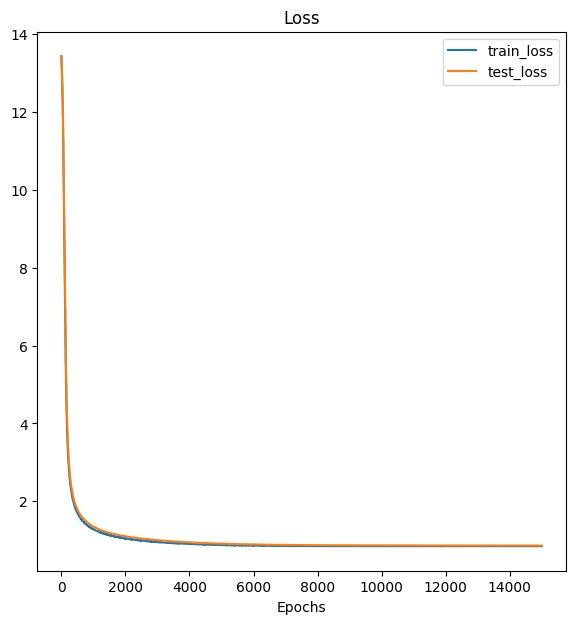

In [81]:
results = train(model=model,
          optimizer = optimizer,
          loss_fn = nn.MSELoss(),                              
          epochs = 15_000,
          device = device,
          scheduler=scheduler)
plot_loss_curves(results)

In [ ]:
class LightGCN(MessagePassing):

    def save(self, fileName):
        torch.save(self.state_dict(), fileName)

    def load(self, fileName, device):
        self.load_state_dict(torch.load(fileName, map_location=device))

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False, dropout_rate=0.1, name='name'):

        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops
        self.name = name
        self.drop1 = nn.Dropout(dropout_rate)


        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0

        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0


        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

        self.out = nn.Linear(embedding_dim + embedding_dim, 1)

    def forward(self, edge_index, r_mat_edge_index):
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # shape: (n_users + n_items) x embedding_dim. 
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list

        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)


        # this is doing the formula8 in LightGCN paper

        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x embedding_dim.
        embs = torch.stack(embs, dim=1)

        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1)

        users_emb_final, items_emb_final = torch.split(emb_final,
                                                       [self.num_users, self.num_items]) # splits into user embeddings and movie embeddings

        src, dest =  r_mat_edge_index[0], r_mat_edge_index[1]

        user_embeds = users_emb_final[src]
        item_embeds = items_emb_final[dest]
        # x.shape: n_ratings x  embedding_dim * 2
        x = torch.cat([user_embeds, item_embeds], dim=1)

        x = self.drop1(x)

        output = self.out(x)

        return output

In [82]:
# defines LightGCN model
class DeepLightGCN(MessagePassing):

    def save(self, fileName):
        torch.save(self.state_dict(), fileName)

    def load(self, fileName, device):
        self.load_state_dict(torch.load(fileName, map_location=device))

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, n_hidden=32, add_self_loops=False, dropout_rate=0.1, name='name'):

        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops
        self.name = name
        self.drop1 = nn.Dropout(dropout_rate)
        self.drop2 = nn.Dropout(dropout_rate)

        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0

        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0


        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

        self.lin1 = nn.Linear(embedding_dim*2, n_hidden)
        self.out = nn.Linear(n_hidden, 1)

    def forward(self, edge_index, r_mat_edge_index):
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # shape: (n_users + n_items) x embedding_dim. 
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0]

        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)


        # this is doing the formula8 in LightGCN paper

        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x emb_vector_len.
        #        e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)

        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1)

        users_emb_final, items_emb_final = torch.split(emb_final,
                                                       [self.num_users, self.num_items]) # splits into user embeddings and movie embeddings

        src, dest =  r_mat_edge_index[0], r_mat_edge_index[1]

        # applying embedding lookup to get embeddings for src nodes and dest nodes in the edge list
        user_embeds = users_emb_final[src]
        item_embeds = items_emb_final[dest]

        # x.shape: n_ratings x  embedding_dim * 2
        x = torch.cat([user_embeds, item_embeds], dim=1)

        x = self.drop1(x)

        x = self.lin1(x)

        x = self.drop2(x)
        
        output = self.out(x)

        return output

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j


In [83]:
model = DeepLightGCN(num_users=num_users, num_items=num_movies, embedding_dim=64, K=1, n_hidden=64, add_self_loops=True, dropout_rate=0.5, name="light_gcn_v2") # best 0.9504
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=0.0001, threshold_mode='rel')

  0%|          | 0/15000 [00:00<?, ?it/s]

Saving new best model.
Epoch: 200 | train_loss: 1.1101 | train RMSE: 1.0536 | test_loss: 0.9135 | test RMSE: 0.9558 | time: 0.0095 Learning rate: 0.00095
Saving new best model.
Epoch: 400 | train_loss: 0.9818 | train RMSE: 0.9908 | test_loss: 0.8208 | test RMSE: 0.9060 | time: 0.0076 Learning rate: 0.0009025
Saving new best model.
Epoch: 600 | train_loss: 0.9564 | train RMSE: 0.9780 | test_loss: 0.8037 | test RMSE: 0.8965 | time: 0.0081 Learning rate: 0.000857375
Epoch: 800 | train_loss: 0.9563 | train RMSE: 0.9779 | test_loss: 0.8045 | test RMSE: 0.8969 | time: 0.0080 Learning rate: 0.0008145062499999999
Saving new best model.
Epoch: 1000 | train_loss: 0.9438 | train RMSE: 0.9715 | test_loss: 0.8028 | test RMSE: 0.8960 | time: 0.0089 Learning rate: 0.0007737809374999998
Saving new best model.
Epoch: 1200 | train_loss: 0.9366 | train RMSE: 0.9678 | test_loss: 0.8007 | test RMSE: 0.8948 | time: 0.0072 Learning rate: 0.0007350918906249997
Saving new best model.
Epoch: 1400 | train_loss: 

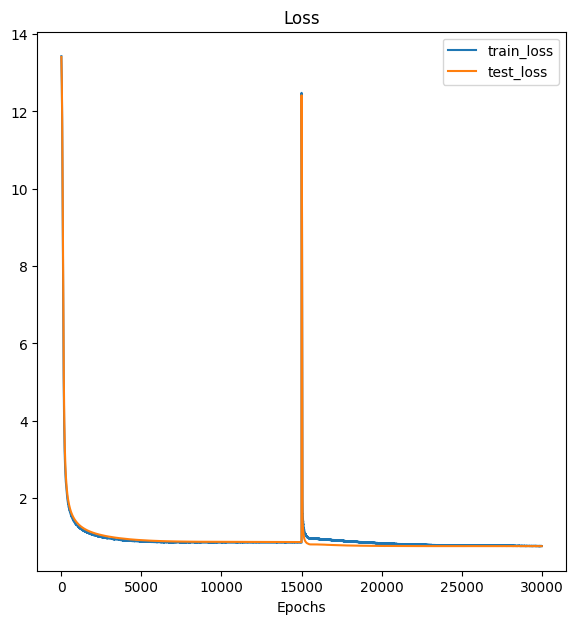

In [84]:
results = train(model=model, #  test_loss: 0.7721 | test RMSE: 0.8787  
          optimizer = optimizer,
          loss_fn = nn.MSELoss(),                              
          epochs = 15_000,
          device = device,
          scheduler=scheduler)
plot_loss_curves(results)